In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

#from model.gru_audio_model import GRUAudioConfig, GRUAudioModel

import matplotlib.pylab as plt
%matplotlib inline

import pickle
import os

from audioDataLoader.mulaw import mu_law_encode, mu_law_decode
from audioDataLoader.audio_dataset import AudioDatasetConfig, MuLawAudioDataset2
from torch.utils.data import DataLoader

import model.gru_audio_model

### Data Params  
<a id="dataparams"></a>

These parameters are pickled to file, and serve several purposes:
* The allow other programs to properly evaluate and visualize the trained (and also saved) models,
* PRovide a record of the parameters that allow reproducing results. 

In [2]:
loadmodel = False #True means load params from disk, and use last saved model running from last saved step 
restartPickledParamFilePath = 'model' + '/2018-11-22_11-41-42_modelParams.pkl'

if loadmodel == True :  # ------------   get params from file
    with open(restartPickledParamFilePath, 'rb') as input:
        params = pickle.load(input) 
    loadmodelfile=params['savemodeldir'] + '/' + params['savedModel']
    #override any of the saved params
    params['batches_per_epoch']= 2000 #in addition to whatever was already run
    
else : # ---------------------    New run, set the params
    ##**  sourcedatadir='./data/nsynth.64.76.dl'
    sourcedatadir='./data/nsynth.64.76.dl_new'
    ##**  sourcedatadir='./data/nsynth2foo'
 

    params = dict(
        # Read/write directory of data & parameter files
        #*************************************
        sample_rate=16000,
        runTimeStamp='{:%Y-%m-%d_%H-%M-%S}'.format(datetime.now()),
        
        datadir = sourcedatadir,
        paramdir = sourcedatadir,

        savemodel = True,
        savemodel_interval = 100, #200,  # If 0 (and savemodel=True) will only save model at the end of entire training
        savemodeldir = os.getcwd() + '/output', #default saving directory for models and the parameterization
        savedModel='', #updated at savemodel_interval
        savedSteps=0,  #updated at savemodel_interval
        
        batches_per_epoch = 100, #1000,  #10000, #max number batches of steps per epoch (typically num_epochs=1)
        batch_size = 256, #256,
        num_epochs = 10,


        # Training parameters
        #*************************************
        noise=.1,
        seqLen = 256, 
        stride = 1,
        
        lr = 0.005,
        props=['instID','amplitude','midiPitch'],
        
        # Model parameters
        hiddenSize = 48, #100,
        nLayers = 4,

    )

### Run Params 

In [3]:
gru_config = model.gru_audio_model.GRUAudioConfig (
    input_size = 1,
    cond_size = len(params['props']),
    hidden_size = params['hiddenSize'],
    num_layers = params['nLayers'],
    output_size = 256,  #mu-law quantization levels
    dropout = 0.1
)

sr = params['sample_rate']

batches_per_epoch = params['batches_per_epoch'] #batches per eposh
k_previousRunSteps=params['savedSteps']
log_interval = 50
visualize_interval = 100

#Generation parameters
#*************************************
max_length = params['seqLen']*3

# Cuda
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
params

{'sample_rate': 16000,
 'runTimeStamp': '2025-08-05_15-14-47',
 'datadir': './data/nsynth.64.76.dl_new',
 'paramdir': './data/nsynth.64.76.dl_new',
 'savemodel': True,
 'savemodel_interval': 100,
 'savemodeldir': '/home/lonce/working/RNNControl2/output',
 'savedModel': '',
 'savedSteps': 0,
 'batches_per_epoch': 100,
 'batch_size': 256,
 'num_epochs': 10,
 'noise': 0.1,
 'seqLen': 256,
 'stride': 1,
 'lr': 0.005,
 'props': ['instID', 'amplitude', 'midiPitch'],
 'hiddenSize': 48,
 'nLayers': 4}

In [4]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

def inputcoding(samp) :
    return mu_law_encode(np.array(samp))/255.

def index2float(topi) :
    return(mu_law_decode(topi[0][0]).cpu().numpy())
    
# class foo_targetcoding:
#     @staticmethod
#     def index2float(topi):
#         #return (topi[0][0]/255.0).cpu().numpy() *2.-1.
#         return(mu_law_decode(topi[0][0]).cpu().numpy())
#     def __call__(self, samp):
#         return mu_law_encode(np.array(samp))
# targetcoding = foo_targetcoding()


In [5]:

# ---- Training Settings ----
data_config = AudioDatasetConfig(
   data_dir=params['datadir'],
   sequence_length=params['seqLen'],
   parameter_specs={"instID": (1, 2), "a": (0,1), "p": (64.0, 76.0)},
   add_noise= False if params['noise'] == 0 else True,   # Whether to add white noise
   noise_weight = params['noise'],                           # Desired signal-to-noise ratio (dB)
   encode=True
)

# ---- Generation Settings ----
testdata_config = AudioDatasetConfig(
   data_dir=params['datadir'],
   sequence_length=params['seqLen'],
   parameter_specs={"instID": (1, 2), "a": (0,1), "p": (64.0, 76.0)},
   add_noise= False,                        # no noise for testing and priming
   noise_weight = params['noise'],                           # Desired signal-to-noise ratio (dB)
   encode=False
)

# === Dataset and Loader ===
adataset = MuLawAudioDataset2(data_config)
train_loader = DataLoader(adataset,
                             batch_size=params['batch_size'],
                             shuffle=True,
                             num_workers=4,
                             drop_last=True)

testdataset = MuLawAudioDataset2(testdata_config)
test_loader = DataLoader(testdataset,
                            batch_size=1,
                            shuffle=True,
                            num_workers=4,
                            drop_last=True)
   

print("size of dataset is",len(adataset))
print("no. of batches per epoch is", params['batches_per_epoch'])
print("batchsize id  is", params['batch_size'])

size of dataset is 10333440
no. of batches per epoch is 100
batchsize id  is 256


size of dataset is 10333440
no. of batches per epoch is 100
batchsize id  is 256
rand_sample: idx=4685817
rand_sample: file_idx=117
rand_sample: start_pos=35769, end_pos=36026
torch.Size([257])


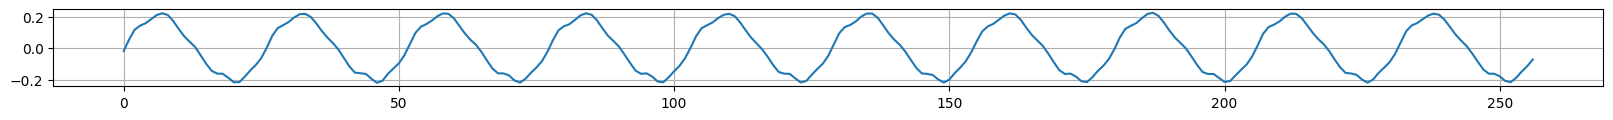

/tmp/ipykernel_454903/1167469217.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return mu_law_encode(np.array(samp))/255.


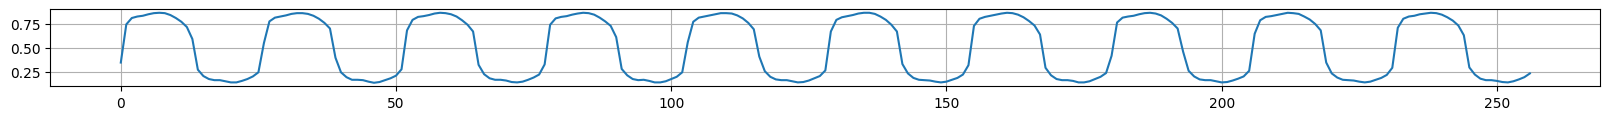

Do it! 2025-08-05 15:14:48
bat num 0 at time 2025-08-05 15:14:48
x_audio_seq.shape = torch.Size([1, 256, 4])
y_target_seq.shape = torch.Size([1, 256, 1])
bat num 1 at time 2025-08-05 15:14:48
x_audio_seq.shape = torch.Size([1, 256, 4])
y_target_seq.shape = torch.Size([1, 256, 1])
finished at 2025-08-05 15:14:48


In [6]:
# show stuff

print("size of dataset is",len(adataset))
print("no. of batches per epoch is", params['batches_per_epoch'])
print("batchsize id  is", params['batch_size'])

samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

samp = inputcoding(samp)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()


n_batches = 1
print("Do it! {}".format(mydate()))
for bat, (x_audio_seq, y_target_seq) in enumerate(test_loader):
    print("bat num {} at time {}".format(bat, mydate()))
    print(f"x_audio_seq.shape = {x_audio_seq.shape}") 
    print(f"y_target_seq.shape = {y_target_seq.shape}")
    if bat >= n_batches :
        break;
print("finished at {}".format(mydate()))

# print(f"x_audio_seq[0,:,0] seq is {x_audio_seq[0,:,0]}")
# print(f"x_audio_seq[0,:,1] seq is {x_audio_seq[0,:,1]}")
# print(f"x_audio_seq[0,:,2] seq is {x_audio_seq[0,:,2]}")
# print(f"x_audio_seq[0,:,3] seq is {x_audio_seq[0,:,3]}")
# print(f"y_target_seq[0,:] seq is {y_target_seq[0,:].squeeze(-1)}")


In [7]:
 # Define the training cycle (100% teacher forcing for now)
 #*************************************
 
 def train(model,epoch):
 
 
     model.train() #put in training mode
     ave_loss_over_steps = 0
 
     debug_seqs=0
 
     for batch_num, (inp, target) in enumerate(train_loader):
 
         if batch_num==0:
             print(f"train() - inp[:,:,0] - Min: {torch.min(inp[:,:,0])}, Max: {torch.max(inp[:,:,0])}, Average: {torch.mean(inp[:,:,0])}")
 
 
         debug_seqs=debug_seqs+len(x_audio_seq) # summing the batch length for each batch_num
 
         inp, target = inp.to(device), target.to(device)
         # Forward + Backward + Optimize
         hidden = model.init_hidden(params['batch_size'])
         optimizer.zero_grad()
         loss = 0
 
         #print(f" inp[0,127,0] (B,T,p) is {inp[0,127,0]}")
 
         # iterate through the SEQUENCE
         for i in range(params['seqLen']):
             outputs, hidden = model(inp[:,i,:],hidden,params['batch_size'])  #input dim: (batch, seq, feature)
             loss += criterion(outputs, torch.squeeze(target[:,i],1))
             #print(f"timestep {i} target is {torch.squeeze(target[:,i],1)}")
 
         loss.backward()
         optimizer.step()
 
         ave_loss_per_sample = loss.item()/params['seqLen']   #over each minibatch
         ave_loss_over_steps += ave_loss_per_sample
 
         if (batch_num+1) % log_interval == 0:
             print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], batch_num [{}/{}] Loss: {:.4f}'.format(
                 datetime.now(), epoch+1, params['num_epochs'], batch_num+1, params['batches_per_epoch'], ave_loss_over_steps/log_interval))
 
             list_of_losses.append(ave_loss_over_steps/log_interval)
             ave_loss_over_steps = 0
 
 
         if (batch_num+1) % visualize_interval == 0:
             result = generate(model,max_length)
             plt.figure(figsize=(20,1))
             plt.plot(np.arange(len(result)), result) #just print one example from the batch
             plt.show()
             model.train() #put model back to training mode
 
         if (batch_num+1) % params['savemodel_interval'] == 0 and params['savemodel'] and params['savemodel_interval'] != 0:
             lastSavedStep=k_previousRunSteps+batch_num+1
             lastSavedModel=params['runTimeStamp']+'_model_epoch{}_batch_num{}.pth'.format(epoch+1,lastSavedStep)
             torch.save(model.state_dict(), params['savemodeldir'] + '/' + lastSavedModel)
             print('model saved at epoch {} batch_num {} for this run ({} overall)'.format(epoch+1,batch_num+1, lastSavedStep))
 
             #write (overwrite) the param file for each save so we always have the latest, even if run doesn't complete
             params['savedSteps']=lastSavedStep
             params['savedModel']=lastSavedModel
             with open(params['savemodeldir'] + '/' + params['runTimeStamp'] + '_modelParams.pkl', 'wb') as output:
                     pickle.dump(params, output, pickle.HIGHEST_PROTOCOL)
 
 
         if batch_num>=(batches_per_epoch-1):
             break
 
     print(f"Finished epoch number {epoch} with a total of {debug_seqs} debug_seqs")
 
 
 
 # generate
 #*************************************
 def generate(model,max_length,primer=None,paramvect=None, returnHiddenSequence=False):
     """Generate a signal using the provided model.
     @param max_length of the synthesized signal
     @param primer a torch.tensor of shape (batch=1, primer_signal=primer_length, num_inputs=1+num_cond_parameters)
     @paramvect conditioning parameters  (a function of i, sample number)
     """ 
     if returnHiddenSequence :
         hs=[]
 
     model.eval()
     with torch.no_grad():
 
         for p_inp, target in test_loader:
 
             print(f"generate() - p_inp_inp[:,:,0] - Min: {torch.min(p_inp[:,:,0])}, Max: {torch.max(p_inp[:,:,0])}, Average: {torch.mean(p_inp[:,:,0])}")
 
             if primer is not None:
                 # must clone else primer is changed outside this function
                 p_inp.data=primer.clone()
             print(f"p_inp = {p_inp}")
             seq = np.copy(p_inp[0,:,0])  #extract the original sample
 
             seq_mu = inputcoding(seq)  #mu-law
 
             p_inp[0,:,0] = torch.from_numpy(seq_mu).float() #now we have both the original and mu-lawed samples
             break
         generated = seq # before mu-law audio encoding
 
         p_inp = p_inp.to(device)
         #print("p_inp",p_inp)
 
         hidden = model.init_hidden()
         if returnHiddenSequence :
             hs.append(torch.squeeze(hidden).cpu().numpy())
 
         print(f"---AND the p_inp we will use to build hidden is {p_inp[0,0:10,:]}")
         for j in range(params['seqLen']-1):  #build up hidden state
             _, hidden = model(p_inp[:,j,:],hidden)
         inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
 
         #print("last inp from primer",inp)
 
         for i in range(max_length):
             outputs, hidden = model(inp,hidden)
 
             outputs = nn.functional.log_softmax(outputs,dim=1)
             topv, topi = outputs.detach().topk(1)  #choose the strongest activation
             #print(topv,topv.shape)
             predicted_sample = index2float(topi)
 
             generated = np.append(generated,predicted_sample)
 
             inp[:,0] = torch.from_numpy(inputcoding([predicted_sample])).type(torch.cuda.FloatTensor)
             #print("input",inp)
             #print("shape",inp.shape)
             if paramvect is not None:
                 inp[:,1:] = torch.tensor(paramvect(i))
                 #print("input2",inp)
 
             if returnHiddenSequence :
                 hs.append(torch.squeeze(hidden).cpu().numpy())
 
         if returnHiddenSequence :
             return generated, hs
         else :
             return generated


<a href="#dataparams">Go To Data Params</a>

In [8]:

rnn = model.gru_audio_model.RNN(gru_config).to(device)

if loadmodel: # load checkpoint if needed
 print("Loading existing checkpoint...")
 rnn.load_state_dict(torch.load(loadmodelfile))
    
optimizer = torch.optim.Adam(rnn.parameters(), lr=params['lr'])
criterion = nn.CrossEntropyLoss()


In [9]:
num_trainable_params = sum(p.numel() for p in rnn.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_trainable_params}")

Trainable parameters: 69232


2025-08-05 15:14:49 Starting training...
train() - inp[:,:,0] - Min: 0.07450980693101883, Max: 0.9372549057006836, Average: 0.4946458637714386
2025-08-05 15:14:57 Epoch [1/10], batch_num [50/100] Loss: 4.9263
2025-08-05 15:15:05 Epoch [1/10], batch_num [100/100] Loss: 4.5085
generate() - p_inp_inp[:,:,0] - Min: -0.08106689900159836, Max: 0.076416015625, Average: -0.0009419918060302734
p_inp = tensor([[[ 1.7603e-02,  0.0000e+00,  2.0000e-01,  0.0000e+00],
         [ 6.1646e-03,  0.0000e+00,  2.0000e-01,  0.0000e+00],
         [-6.6284e-03,  0.0000e+00,  2.0000e-01,  0.0000e+00],
         ...,
         [-1.4453e-02,  0.0000e+00,  2.0000e-01,  0.0000e+00],
         [-1.2207e-04,  0.0000e+00,  2.0000e-01,  0.0000e+00],
         [ 1.8860e-02,  0.0000e+00,  2.0000e-01,  0.0000e+00]]])
---AND the p_inp we will use to build hidden is tensor([[0.6549, 0.0000, 0.2000, 0.0000],
        [0.5843, 0.0000, 0.2000, 0.0000],
        [0.4118, 0.0000, 0.2000, 0.0000],
        [0.3373, 0.0000, 0.2000, 0.0

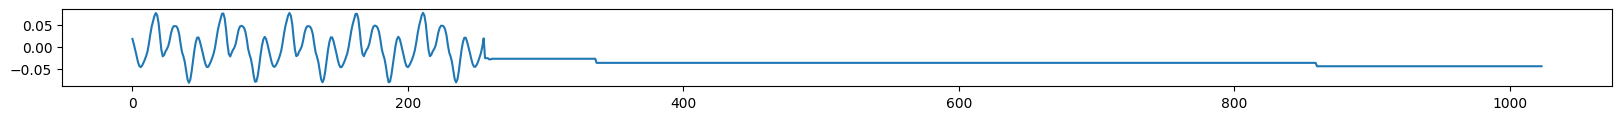

model saved at epoch 1 batch_num 100 for this run (100 overall)
Finished epoch number 0 with a total of 100 debug_seqs
train() - inp[:,:,0] - Min: 0.07450980693101883, Max: 0.9686274528503418, Average: 0.4940599799156189
2025-08-05 15:15:15 Epoch [2/10], batch_num [50/100] Loss: 4.0629
2025-08-05 15:15:23 Epoch [2/10], batch_num [100/100] Loss: 3.7737
generate() - p_inp_inp[:,:,0] - Min: -0.32934263348579407, Max: 0.24436339735984802, Average: -0.007810092065483332
p_inp = tensor([[[-0.1437,  0.0000,  0.7000,  0.5000],
         [-0.1255,  0.0000,  0.7000,  0.5000],
         [-0.0785,  0.0000,  0.7000,  0.5000],
         ...,
         [-0.1223,  0.0000,  0.7000,  0.5000],
         [-0.0179,  0.0000,  0.7000,  0.5000],
         [ 0.0596,  0.0000,  0.7000,  0.5000]]])
---AND the p_inp we will use to build hidden is tensor([[0.1725, 0.0000, 0.7000, 0.5000],
        [0.1843, 0.0000, 0.7000, 0.5000],
        [0.2235, 0.0000, 0.7000, 0.5000],
        [0.2824, 0.0000, 0.7000, 0.5000],
        

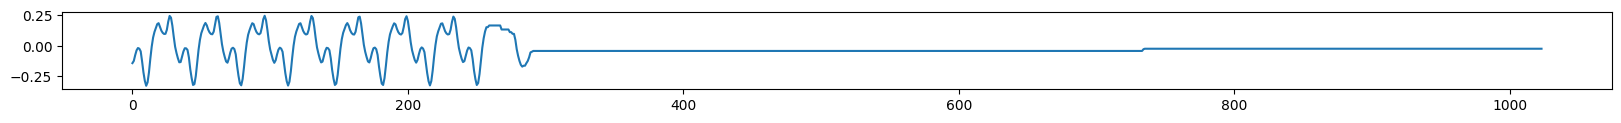

model saved at epoch 2 batch_num 100 for this run (100 overall)
Finished epoch number 1 with a total of 100 debug_seqs
train() - inp[:,:,0] - Min: 0.08627451211214066, Max: 0.9647058844566345, Average: 0.49221497774124146
2025-08-05 15:15:32 Epoch [3/10], batch_num [50/100] Loss: 3.6325
2025-08-05 15:15:41 Epoch [3/10], batch_num [100/100] Loss: 3.5322
generate() - p_inp_inp[:,:,0] - Min: -0.23627929389476776, Max: 0.3037353456020355, Average: 0.0019221310503780842
p_inp = tensor([[[-0.0580,  0.0000,  0.8000,  0.7500],
         [-0.0096,  0.0000,  0.8000,  0.7500],
         [ 0.0200,  0.0000,  0.8000,  0.7500],
         ...,
         [-0.2265,  0.0000,  0.8000,  0.7500],
         [-0.2336,  0.0000,  0.8000,  0.7500],
         [-0.2111,  0.0000,  0.8000,  0.7500]]])
---AND the p_inp we will use to build hidden is tensor([[0.2510, 0.0000, 0.8000, 0.7500],
        [0.3882, 0.0000, 0.8000, 0.7500],
        [0.6627, 0.0000, 0.8000, 0.7500],
        [0.7059, 0.0000, 0.8000, 0.7500],
        

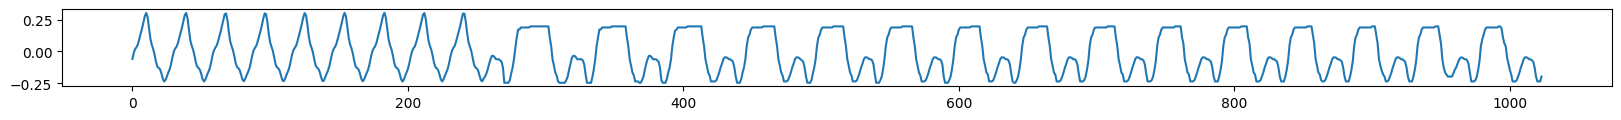

model saved at epoch 3 batch_num 100 for this run (100 overall)
Finished epoch number 2 with a total of 100 debug_seqs
train() - inp[:,:,0] - Min: 0.08235294371843338, Max: 0.9843137264251709, Average: 0.4927886128425598
2025-08-05 15:15:50 Epoch [4/10], batch_num [50/100] Loss: 3.4505
2025-08-05 15:15:58 Epoch [4/10], batch_num [100/100] Loss: 3.3755
generate() - p_inp_inp[:,:,0] - Min: -0.05935058742761612, Max: 0.12965087592601776, Average: -0.00016145710833370686
p_inp = tensor([[[-0.0161,  1.0000,  0.2000,  0.4167],
         [-0.0377,  1.0000,  0.2000,  0.4167],
         [-0.0442,  1.0000,  0.2000,  0.4167],
         ...,
         [ 0.0074,  1.0000,  0.2000,  0.4167],
         [-0.0082,  1.0000,  0.2000,  0.4167],
         [-0.0333,  1.0000,  0.2000,  0.4167]]])
---AND the p_inp we will use to build hidden is tensor([[0.3529, 1.0000, 0.2000, 0.4167],
        [0.2863, 1.0000, 0.2000, 0.4167],
        [0.2745, 1.0000, 0.2000, 0.4167],
        [0.2863, 1.0000, 0.2000, 0.4167],
      

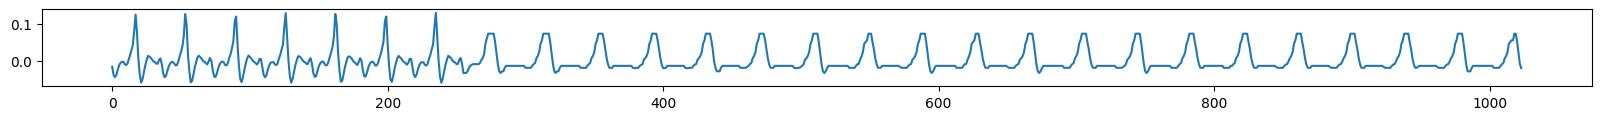

model saved at epoch 4 batch_num 100 for this run (100 overall)
Finished epoch number 3 with a total of 100 debug_seqs
train() - inp[:,:,0] - Min: 0.0784313753247261, Max: 0.95686274766922, Average: 0.49160629510879517
2025-08-05 15:16:08 Epoch [5/10], batch_num [50/100] Loss: 3.3204
2025-08-05 15:16:16 Epoch [5/10], batch_num [100/100] Loss: 3.5066
generate() - p_inp_inp[:,:,0] - Min: -0.3631805181503296, Max: 0.29322507977485657, Average: 0.0031405449844896793
p_inp = tensor([[[ 0.0084,  0.0000,  0.9000,  0.2500],
         [-0.0580,  0.0000,  0.9000,  0.2500],
         [-0.0545,  0.0000,  0.9000,  0.2500],
         ...,
         [ 0.1913,  0.0000,  0.9000,  0.2500],
         [ 0.2676,  0.0000,  0.9000,  0.2500],
         [ 0.2932,  0.0000,  0.9000,  0.2500]]])
---AND the p_inp we will use to build hidden is tensor([[0.6039, 0.0000, 0.9000, 0.2500],
        [0.2510, 0.0000, 0.9000, 0.2500],
        [0.2549, 0.0000, 0.9000, 0.2500],
        [0.3294, 0.0000, 0.9000, 0.2500],
        [0.

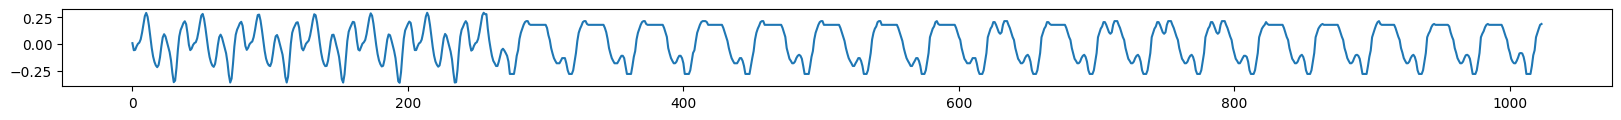

model saved at epoch 5 batch_num 100 for this run (100 overall)
Finished epoch number 4 with a total of 100 debug_seqs
train() - inp[:,:,0] - Min: 0.07450980693101883, Max: 0.9372549057006836, Average: 0.49253642559051514
2025-08-05 15:16:26 Epoch [6/10], batch_num [50/100] Loss: 3.2333
2025-08-05 15:16:34 Epoch [6/10], batch_num [100/100] Loss: 3.2031
generate() - p_inp_inp[:,:,0] - Min: -0.16412353515625, Max: 0.13084717094898224, Average: -0.00017542844580020756
p_inp = tensor([[[ 0.0283,  0.0000,  0.4000,  0.3333],
         [ 0.0100,  0.0000,  0.4000,  0.3333],
         [-0.0127,  0.0000,  0.4000,  0.3333],
         ...,
         [ 0.0168,  0.0000,  0.4000,  0.3333],
         [ 0.0430,  0.0000,  0.4000,  0.3333],
         [ 0.0816,  0.0000,  0.4000,  0.3333]]])
---AND the p_inp we will use to build hidden is tensor([[0.6902, 0.0000, 0.4000, 0.3333],
        [0.6157, 0.0000, 0.4000, 0.3333],
        [0.3686, 0.0000, 0.4000, 0.3333],
        [0.2941, 0.0000, 0.4000, 0.3333],
        

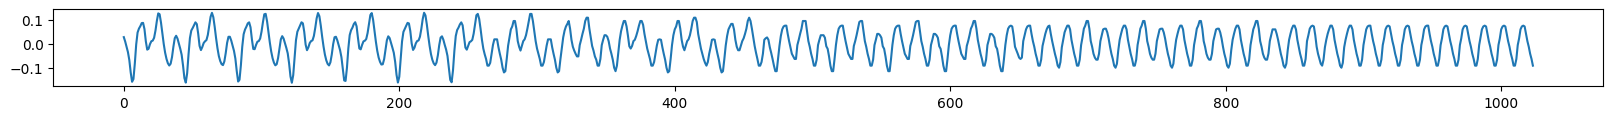

model saved at epoch 6 batch_num 100 for this run (100 overall)
Finished epoch number 5 with a total of 100 debug_seqs
train() - inp[:,:,0] - Min: 0.0784313753247261, Max: 0.9607843160629272, Average: 0.49294513463974
2025-08-05 15:16:43 Epoch [7/10], batch_num [50/100] Loss: 3.1788
2025-08-05 15:16:51 Epoch [7/10], batch_num [100/100] Loss: 3.1230
generate() - p_inp_inp[:,:,0] - Min: -0.06395263969898224, Max: 0.16232910752296448, Average: 0.0001304149627685547
p_inp = tensor([[[ 0.1578,  1.0000,  0.4000,  1.0000],
         [ 0.1075,  1.0000,  0.4000,  1.0000],
         [-0.0060,  1.0000,  0.4000,  1.0000],
         ...,
         [-0.0264,  1.0000,  0.4000,  1.0000],
         [-0.0175,  1.0000,  0.4000,  1.0000],
         [-0.0229,  1.0000,  0.4000,  1.0000]]])
---AND the p_inp we will use to build hidden is tensor([[0.8353, 1.0000, 0.4000, 1.0000],
        [0.8000, 1.0000, 0.4000, 1.0000],
        [0.4157, 1.0000, 0.4000, 1.0000],
        [0.2667, 1.0000, 0.4000, 1.0000],
        [0.

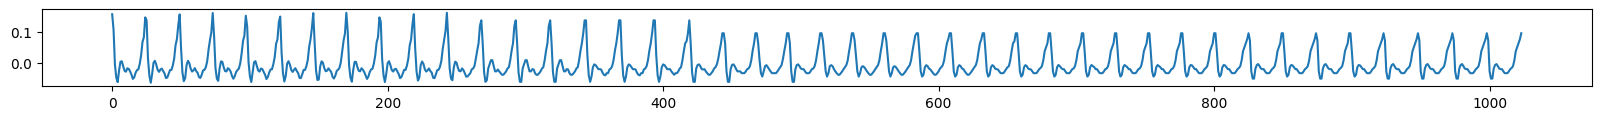

model saved at epoch 7 batch_num 100 for this run (100 overall)
Finished epoch number 6 with a total of 100 debug_seqs
train() - inp[:,:,0] - Min: 0.07058823853731155, Max: 0.95686274766922, Average: 0.49365562200546265
2025-08-05 15:17:01 Epoch [8/10], batch_num [50/100] Loss: 3.0978
2025-08-05 15:17:09 Epoch [8/10], batch_num [100/100] Loss: 3.0668
generate() - p_inp_inp[:,:,0] - Min: -0.10910644382238388, Max: 0.19816894829273224, Average: -0.00085191719699651
p_inp = tensor([[[ 0.1782,  1.0000,  0.4000,  0.0000],
         [ 0.1407,  1.0000,  0.4000,  0.0000],
         [-0.0173,  1.0000,  0.4000,  0.0000],
         ...,
         [-0.0179,  1.0000,  0.4000,  0.0000],
         [-0.0133,  1.0000,  0.4000,  0.0000],
         [-0.0093,  1.0000,  0.4000,  0.0000]]])
---AND the p_inp we will use to build hidden is tensor([[0.8471, 1.0000, 0.4000, 0.0000],
        [0.8235, 1.0000, 0.4000, 0.0000],
        [0.3490, 1.0000, 0.4000, 0.0000],
        [0.2039, 1.0000, 0.4000, 0.0000],
        [0

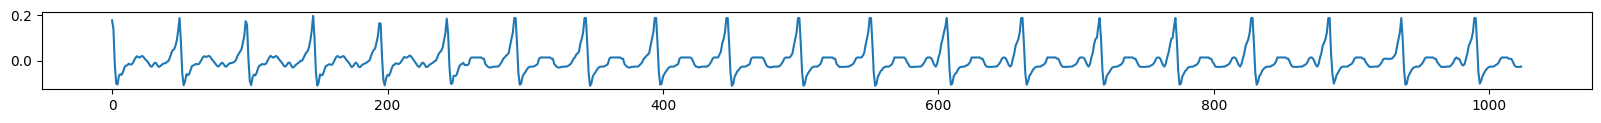

model saved at epoch 8 batch_num 100 for this run (100 overall)
Finished epoch number 7 with a total of 100 debug_seqs
train() - inp[:,:,0] - Min: 0.08627451211214066, Max: 0.9647058844566345, Average: 0.4928692579269409
2025-08-05 15:17:18 Epoch [9/10], batch_num [50/100] Loss: 3.0297
2025-08-05 15:17:26 Epoch [9/10], batch_num [100/100] Loss: 3.0186
generate() - p_inp_inp[:,:,0] - Min: -0.21437989175319672, Max: 0.26130372285842896, Average: -0.005622482858598232
p_inp = tensor([[[-0.1497,  0.0000,  0.8000,  0.8333],
         [-0.1849,  0.0000,  0.8000,  0.8333],
         [-0.2107,  0.0000,  0.8000,  0.8333],
         ...,
         [-0.0728,  0.0000,  0.8000,  0.8333],
         [-0.0285,  0.0000,  0.8000,  0.8333],
         [ 0.0119,  0.0000,  0.8000,  0.8333]]])
---AND the p_inp we will use to build hidden is tensor([[0.1686, 0.0000, 0.8000, 0.8333],
        [0.1490, 0.0000, 0.8000, 0.8333],
        [0.1373, 0.0000, 0.8000, 0.8333],
        [0.1412, 0.0000, 0.8000, 0.8333],
        

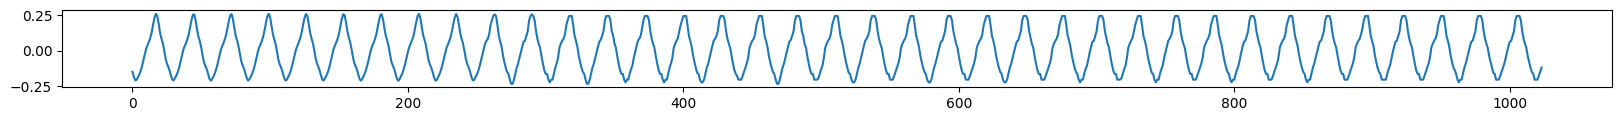

model saved at epoch 9 batch_num 100 for this run (100 overall)
Finished epoch number 8 with a total of 100 debug_seqs
train() - inp[:,:,0] - Min: 0.06666667014360428, Max: 0.95686274766922, Average: 0.492560476064682
2025-08-05 15:17:36 Epoch [10/10], batch_num [50/100] Loss: 2.9800
2025-08-05 15:17:44 Epoch [10/10], batch_num [100/100] Loss: 2.9785
generate() - p_inp_inp[:,:,0] - Min: -0.1537017822265625, Max: 0.1577301025390625, Average: 4.398822784423828e-05
p_inp = tensor([[[-0.0480,  0.0000,  0.5000,  0.9167],
         [-0.0883,  0.0000,  0.5000,  0.9167],
         [-0.1140,  0.0000,  0.5000,  0.9167],
         ...,
         [ 0.0577,  0.0000,  0.5000,  0.9167],
         [ 0.0334,  0.0000,  0.5000,  0.9167],
         [ 0.0136,  0.0000,  0.5000,  0.9167]]])
---AND the p_inp we will use to build hidden is tensor([[0.2667, 0.0000, 0.5000, 0.9167],
        [0.2157, 0.0000, 0.5000, 0.9167],
        [0.1922, 0.0000, 0.5000, 0.9167],
        [0.1922, 0.0000, 0.5000, 0.9167],
        [0.

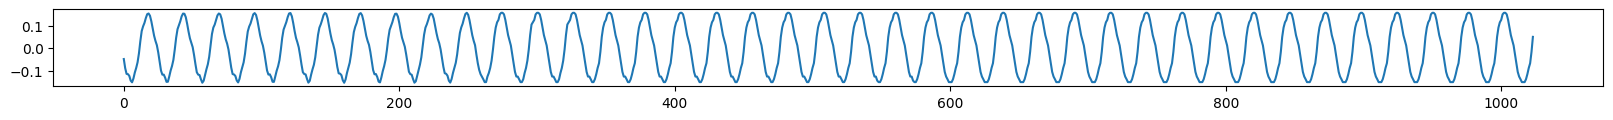

model saved at epoch 10 batch_num 100 for this run (100 overall)
Finished epoch number 9 with a total of 100 debug_seqs
Training time taken: 0:02:56


In [10]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(params['num_epochs']):
    train(rnn,epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

if params['savemodel_interval'] == 0 and params['savemodel']:
    torch.save(model.state_dict(), 
       '{}/{}_model_epoch{}.pth'.format(params['savemodeldir'],params['runTimeStamp'],params['num_epochs']))
    print('model saved at epoch{}'.format(params['num_epochs']))

In [11]:
list_of_losses

[4.926296663284302,
 4.5084820652008055,
 4.062941827774048,
 3.7737432050704958,
 3.6325028228759764,
 3.532152452468872,
 3.450522360801697,
 3.375524139404297,
 3.3203997659683226,
 3.506554226875305,
 3.2333387565612792,
 3.2030829620361327,
 3.1788190841674804,
 3.12296480178833,
 3.0977660322189333,
 3.0667563247680665,
 3.0297377729415893,
 3.0186298274993897,
 2.9800276231765745,
 2.978454170227051]

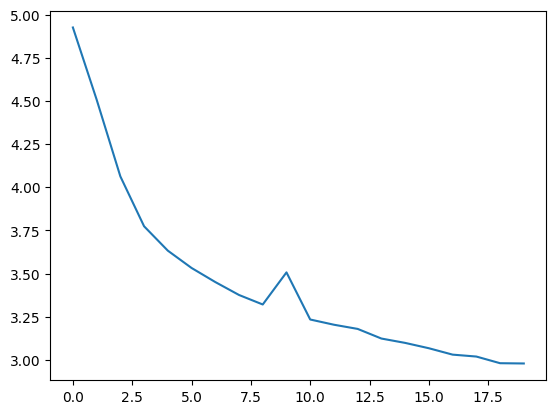

In [12]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)
plt.show()  # This will actually display the plot

In [13]:
foo=[[0.20784315]]
foo[0][0]

0.20784315

In [14]:
list_of_losses

[4.926296663284302,
 4.5084820652008055,
 4.062941827774048,
 3.7737432050704958,
 3.6325028228759764,
 3.532152452468872,
 3.450522360801697,
 3.375524139404297,
 3.3203997659683226,
 3.506554226875305,
 3.2333387565612792,
 3.2030829620361327,
 3.1788190841674804,
 3.12296480178833,
 3.0977660322189333,
 3.0667563247680665,
 3.0297377729415893,
 3.0186298274993897,
 2.9800276231765745,
 2.978454170227051]